In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install tensorflow
!pip install tflite_support
!pip install flatbuffers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 24.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 31.2 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 26.7 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1
ERROR: pip's dependency resolver does not currently take into a

In [3]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix


from tflite_support import metadata_schema_py_generated as _metadata_fb
from tflite_support import metadata as _metadata
import flatbuffers

In [4]:
IMAGES_PATH = "../input/citypersondata/leftImg8bit_trainvaltest/leftImg8bit"
ANNOTS_PATH = "../input/citypersondata/gtBboxCityPersonsWithDangerLevel/gtBboxCityPersonsWithDangerLevel"
BASE_OUTPUT = "output"

TRAIN_FILENAMES = "../input/citypersondata-annot/train.txt"
TEST_FILENAMES = "../input/citypersondata-annot/test.txt"
VAL_FILENAMES = "../input/citypersondata-annot/val.txt"

NUM_CLASSES = 3
OUTPUT_CLASSES = 4 #classes + background

INIT_LR = 1e-4
NUM_EPOCHS = 1
BATCH_SIZE = 16
BUFFER_SIZE = 40

IMG_H = 512#224#512 #384 #360
IMG_W = 512 #224 #512 #512 #480

In [5]:
def getClassFromJson(json_path):
    json_f = open(json_path)
    data = json.load(json_f)
    objects = data["objects"]
    highest_num = 0
    for o in objects:
        danger_level = None
        if "danger_level" in o:
            danger_level = int(o["danger_level"])
        else:
            danger_level = int(o["my_label"])
        
        
        if highest_num < danger_level:
            highest_num = danger_level
        if highest_num == 3:
            break
    return highest_num

In [6]:
def returnNamesLabels(filename):
    trainDataNames = []
    trainDataLabels = []
    f = open(filename, "r")
    for r in f:
        r = r.split(",") #image path, annotation path
        img_path = r[0]
        annot_path = r[1][:-1] #without \n
        class_num = getClassFromJson(annot_path)
        trainDataNames.append(img_path)
        trainDataLabels.append(class_num)
    f.close()
    return trainDataNames, trainDataLabels

In [7]:
trainDataNames, trainDataLabels = returnNamesLabels(TRAIN_FILENAMES)
valDataNames, valDataLabels = returnNamesLabels(VAL_FILENAMES)
testDataNames, testDataLabels = returnNamesLabels(TEST_FILENAMES)

allDataNames = trainDataNames + valDataNames + testDataNames
allDataLabels = trainDataLabels + valDataLabels + testDataLabels

In [8]:
X_train, X_test, y_train, y_test = train_test_split(allDataNames, allDataLabels, test_size=0.1438, random_state=42, shuffle=True, stratify=allDataLabels)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.122689, random_state=42, shuffle=True, stratify=y_train)

In [9]:
print(len(y_test))
print(len(y_train))
print(len(y_val))

STEPS_PER_EPOCH = len(y_train) // BATCH_SIZE

500
2610
365


In [10]:
def showDataPlot(trainDataLabels):
    l = []
    for i in trainDataLabels:
        if i == 0:
            l.append("ignore")
        elif i == 1:
            l.append("safe pedestrian")
        elif i == 2:
            l.append("be careful")
        elif i == 3:
            l.append("break")
        else:
            print("should not happen")
    sns.set_style('darkgrid')
    sns.countplot(x=l, order=["ignore", "safe pedestrian", "be careful", "break"])
    print("ignore: " + str(l.count("ignore")))
    print("safe pedestrian: " + str(l.count("safe pedestrian")))
    print("be careful: " + str(l.count("be careful")))
    print("break: " + str(l.count("break")))

ignore: 401
safe pedestrian: 1500
be careful: 471
break: 238


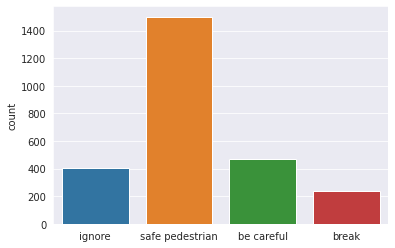

In [11]:
showDataPlot(y_train)

ignore: 56
safe pedestrian: 210
be careful: 66
break: 33


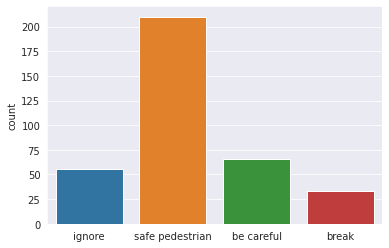

In [12]:
showDataPlot(y_val)

ignore: 77
safe pedestrian: 287
be careful: 90
break: 46


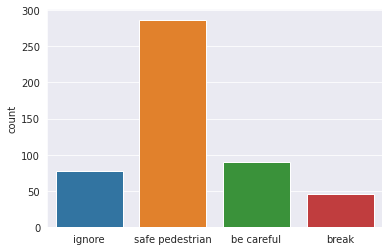

In [13]:
showDataPlot(y_test)

In [14]:
def normalize(input_image, label):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, label

def read_image(image_path, h, w):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    return tf.image.resize(image, [h, w])

def load_image(image_path, label, imageH, imageW):
    input_image = read_image(image_path, imageH, imageW)
    input_image, label = normalize(input_image, label)
    return input_image, label

In [15]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_images = dataset_train.map(lambda x, y: load_image(x, y, IMG_H, IMG_W), num_parallel_calls=tf.data.AUTOTUNE)

dataset_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_images = dataset_val.map(lambda x, y: load_image(x, y, IMG_H, IMG_W), num_parallel_calls=tf.data.AUTOTUNE)

2023-01-04 18:45:19.190430: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        return inputs, labels

In [17]:
train_batches = (
        train_images
        .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .repeat()
        .map(Augment())
        .prefetch(buffer_size=tf.data.AUTOTUNE))

In [18]:
val_batches = val_images.batch(BATCH_SIZE)

In [19]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (IMG_H, IMG_W, 3), include_top = False, weights = "imagenet")

9420800/9406464 [==============================] - 0s 0us/step


In [20]:
base_model.trainable = True

In [21]:
model = tf.keras.Sequential([base_model,
                                tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(64, activation="relu"),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(32, activation="relu"),
                             tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(4,activation=tf.keras.activations.softmax)
                                ])

In [22]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              loss_weights=[2.5, 0.67, 2.12, 4.2],
              metrics=['accuracy'])


ep = 10
history = model.fit(train_batches,epochs = ep , validation_data = val_batches, steps_per_epoch=STEPS_PER_EPOCH)

2023-01-04 18:45:21.920234: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

  1/163 [..............................] - ETA: 48:46 - loss: 4.2150 - accuracy: 0.0000e+00

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  2/163 [..............................] - ETA: 14:30 - loss: 4.2825 - accuracy: 0.0312    

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  3/163 [..............................] - ETA: 14:06 - loss: 4.3904 - accuracy: 0.0833

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  4/163 [..............................] - ETA: 13:54 - loss: 4.4526 - accuracy: 0.1094

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  5/163 [..............................] - ETA: 13:45 - loss: 4.3694 - accuracy: 0.1250

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  6/163 [>.............................] - ETA: 14:02 - loss: 4.3868 - accuracy: 0.1250

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  7/163 [>.............................] - ETA: 13:50 - loss: 4.3916 - accuracy: 0.1161

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  8/163 [>.............................] - ETA: 13:38 - loss: 4.3643 - accuracy: 0.1094

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  9/163 [>.............................] - ETA: 13:29 - loss: 4.3929 - accuracy: 0.1042

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 10/163 [>.............................] - ETA: 13:20 - loss: 4.3417 - accuracy: 0.1187

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 11/163 [=>............................] - ETA: 13:16 - loss: 4.2770 - accuracy: 0.1307

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 12/163 [=>............................] - ETA: 13:17 - loss: 4.2817 - accuracy: 0.1302

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 13/163 [=>............................] - ETA: 13:10 - loss: 4.2527 - accuracy: 0.1298

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 14/163 [=>............................] - ETA: 13:02 - loss: 4.2168 - accuracy: 0.1295

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 15/163 [=>............................] - ETA: 12:55 - loss: 4.2293 - accuracy: 0.1250

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 16/163 [=>............................] - ETA: 12:48 - loss: 4.1900 - accuracy: 0.1289

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 17/163 [==>...........................] - ETA: 12:42 - loss: 4.1629 - accuracy: 0.1397

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 18/163 [==>...........................] - ETA: 12:41 - loss: 4.1417 - accuracy: 0.1493

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 19/163 [==>...........................] - ETA: 12:35 - loss: 4.1043 - accuracy: 0.1579

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 20/163 [==>...........................] - ETA: 12:28 - loss: 4.0848 - accuracy: 0.1594

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 21/163 [==>...........................] - ETA: 12:25 - loss: 4.0892 - accuracy: 0.1667

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 22/163 [===>..........................] - ETA: 12:19 - loss: 4.0781 - accuracy: 0.1705

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 23/163 [===>..........................] - ETA: 12:13 - loss: 4.0486 - accuracy: 0.1766

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 24/163 [===>..........................] - ETA: 12:10 - loss: 4.0439 - accuracy: 0.1849

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 25/163 [===>..........................] - ETA: 12:04 - loss: 4.0330 - accuracy: 0.1850

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 26/163 [===>..........................] - ETA: 11:57 - loss: 4.0309 - accuracy: 0.1875

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 27/163 [===>..........................] - ETA: 11:51 - loss: 4.0115 - accuracy: 0.1921

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 28/163 [====>.........................] - ETA: 11:45 - loss: 3.9798 - accuracy: 0.1987

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 29/163 [====>.........................] - ETA: 11:39 - loss: 3.9796 - accuracy: 0.1983

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 30/163 [====>.........................] - ETA: 11:36 - loss: 3.9787 - accuracy: 0.2000

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 31/163 [====>.........................] - ETA: 11:30 - loss: 3.9587 - accuracy: 0.2056

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 32/163 [====>.........................] - ETA: 11:24 - loss: 3.9478 - accuracy: 0.2090

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 33/163 [=====>........................] - ETA: 11:18 - loss: 3.9561 - accuracy: 0.2083

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 34/163 [=====>........................] - ETA: 11:14 - loss: 3.9417 - accuracy: 0.2151

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 35/163 [=====>........................] - ETA: 11:07 - loss: 3.9340 - accuracy: 0.2214

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 36/163 [=====>........................] - ETA: 11:02 - loss: 3.9151 - accuracy: 0.2292

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 37/163 [=====>........................] - ETA: 10:58 - loss: 3.9248 - accuracy: 0.2280

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 38/163 [=====>........................] - ETA: 10:53 - loss: 3.9161 - accuracy: 0.2253

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 39/163 [======>.......................] - ETA: 10:47 - loss: 3.9104 - accuracy: 0.2308

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 40/163 [======>.......................] - ETA: 10:41 - loss: 3.9081 - accuracy: 0.2297

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 41/163 [======>.......................] - ETA: 10:36 - loss: 3.9048 - accuracy: 0.2302

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 42/163 [======>.......................] - ETA: 10:30 - loss: 3.8820 - accuracy: 0.2351

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 43/163 [======>.......................] - ETA: 10:27 - loss: 3.8547 - accuracy: 0.2442

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 44/163 [=======>......................] - ETA: 10:21 - loss: 3.8521 - accuracy: 0.2443

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 45/163 [=======>......................] - ETA: 10:15 - loss: 3.8397 - accuracy: 0.2472

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 46/163 [=======>......................] - ETA: 10:10 - loss: 3.8248 - accuracy: 0.2514

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 47/163 [=======>......................] - ETA: 10:04 - loss: 3.8108 - accuracy: 0.2566

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 48/163 [=======>......................] - ETA: 9:58 - loss: 3.8035 - accuracy: 0.2565 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 49/163 [========>.....................] - ETA: 9:55 - loss: 3.7877 - accuracy: 0.2615

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 50/163 [========>.....................] - ETA: 9:49 - loss: 3.7779 - accuracy: 0.2625

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 51/163 [========>.....................] - ETA: 9:44 - loss: 3.7747 - accuracy: 0.2672

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 52/163 [========>.....................] - ETA: 9:39 - loss: 3.7746 - accuracy: 0.2680

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 53/163 [========>.....................] - ETA: 9:34 - loss: 3.7916 - accuracy: 0.2642

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 54/163 [========>.....................] - ETA: 9:28 - loss: 3.7812 - accuracy: 0.2697

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 55/163 [=========>....................] - ETA: 9:25 - loss: 3.7725 - accuracy: 0.2705

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 56/163 [=========>....................] - ETA: 9:19 - loss: 3.7641 - accuracy: 0.2734

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 57/163 [=========>....................] - ETA: 9:14 - loss: 3.7743 - accuracy: 0.2741

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 58/163 [=========>....................] - ETA: 9:08 - loss: 3.7641 - accuracy: 0.2791

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 59/163 [=========>....................] - ETA: 9:03 - loss: 3.7622 - accuracy: 0.2807

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 60/163 [==========>...................] - ETA: 8:57 - loss: 3.7542 - accuracy: 0.2823

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 61/163 [==========>...................] - ETA: 8:53 - loss: 3.7585 - accuracy: 0.2848

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 62/163 [==========>...................] - ETA: 8:48 - loss: 3.7571 - accuracy: 0.2853

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 63/163 [==========>...................] - ETA: 8:42 - loss: 3.7500 - accuracy: 0.2867

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 64/163 [==========>...................] - ETA: 8:37 - loss: 3.7436 - accuracy: 0.2881

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 65/163 [==========>...................] - ETA: 8:31 - loss: 3.7391 - accuracy: 0.2904

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 66/163 [===========>..................] - ETA: 8:26 - loss: 3.7383 - accuracy: 0.2907

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 67/163 [===========>..................] - ETA: 8:22 - loss: 3.7304 - accuracy: 0.2929

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 68/163 [===========>..................] - ETA: 8:17 - loss: 3.7208 - accuracy: 0.2950

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 69/163 [===========>..................] - ETA: 8:11 - loss: 3.7250 - accuracy: 0.2944

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 70/163 [===========>..................] - ETA: 8:06 - loss: 3.7145 - accuracy: 0.2937

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 71/163 [============>.................] - ETA: 8:00 - loss: 3.6972 - accuracy: 0.2984

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 72/163 [============>.................] - ETA: 7:55 - loss: 3.6882 - accuracy: 0.3021

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 73/163 [============>.................] - ETA: 7:50 - loss: 3.6896 - accuracy: 0.3014

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 74/163 [============>.................] - ETA: 7:45 - loss: 3.6859 - accuracy: 0.3032

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 75/163 [============>.................] - ETA: 7:40 - loss: 3.6715 - accuracy: 0.3075

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 76/163 [============>.................] - ETA: 7:35 - loss: 3.6654 - accuracy: 0.3092

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 77/163 [=============>................] - ETA: 7:29 - loss: 3.6707 - accuracy: 0.3084

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 78/163 [=============>................] - ETA: 7:24 - loss: 3.6636 - accuracy: 0.3093

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 79/163 [=============>................] - ETA: 7:19 - loss: 3.6549 - accuracy: 0.3117

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 80/163 [=============>................] - ETA: 7:14 - loss: 3.6521 - accuracy: 0.3133

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 81/163 [=============>................] - ETA: 7:08 - loss: 3.6419 - accuracy: 0.3148

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 82/163 [==============>...............] - ETA: 7:03 - loss: 3.6380 - accuracy: 0.3148

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 83/163 [==============>...............] - ETA: 6:57 - loss: 3.6418 - accuracy: 0.3133

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 84/163 [==============>...............] - ETA: 6:52 - loss: 3.6304 - accuracy: 0.3162

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 85/163 [==============>...............] - ETA: 6:47 - loss: 3.6272 - accuracy: 0.3184

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 86/163 [==============>...............] - ETA: 6:42 - loss: 3.6202 - accuracy: 0.3205

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 87/163 [===============>..............] - ETA: 6:36 - loss: 3.6127 - accuracy: 0.3240

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 88/163 [===============>..............] - ETA: 6:31 - loss: 3.6093 - accuracy: 0.3239

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 89/163 [===============>..............] - ETA: 6:26 - loss: 3.5977 - accuracy: 0.3265

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 90/163 [===============>..............] - ETA: 6:20 - loss: 3.5971 - accuracy: 0.3285

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 91/163 [===============>..............] - ETA: 6:15 - loss: 3.5917 - accuracy: 0.3297

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 92/163 [===============>..............] - ETA: 6:10 - loss: 3.5853 - accuracy: 0.3315

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 93/163 [================>.............] - ETA: 6:05 - loss: 3.5743 - accuracy: 0.3333

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 94/163 [================>.............] - ETA: 6:00 - loss: 3.5642 - accuracy: 0.3351

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 95/163 [================>.............] - ETA: 5:54 - loss: 3.5601 - accuracy: 0.3375

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 96/163 [================>.............] - ETA: 5:49 - loss: 3.5569 - accuracy: 0.3392

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 97/163 [================>.............] - ETA: 5:44 - loss: 3.5540 - accuracy: 0.3421

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 98/163 [=================>............] - ETA: 5:39 - loss: 3.5526 - accuracy: 0.3438

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 99/163 [=================>............] - ETA: 5:34 - loss: 3.5503 - accuracy: 0.3447

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


100/163 [=================>............] - ETA: 5:28 - loss: 3.5437 - accuracy: 0.3462

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


101/163 [=================>............] - ETA: 5:23 - loss: 3.5436 - accuracy: 0.3465

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


102/163 [=================>............] - ETA: 5:18 - loss: 3.5451 - accuracy: 0.3462

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


103/163 [=================>............] - ETA: 5:13 - loss: 3.5385 - accuracy: 0.3489

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


104/163 [==================>...........] - ETA: 5:08 - loss: 3.5457 - accuracy: 0.3486

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


105/163 [==================>...........] - ETA: 5:02 - loss: 3.5440 - accuracy: 0.3512

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/163 [==================>...........] - ETA: 4:57 - loss: 3.5392 - accuracy: 0.3520

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


107/163 [==================>...........] - ETA: 4:52 - loss: 3.5331 - accuracy: 0.3546

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


108/163 [==================>...........] - ETA: 4:46 - loss: 3.5253 - accuracy: 0.3565

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


109/163 [===================>..........] - ETA: 4:41 - loss: 3.5180 - accuracy: 0.3584

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


110/163 [===================>..........] - ETA: 4:36 - loss: 3.5108 - accuracy: 0.3602

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


111/163 [===================>..........] - ETA: 4:31 - loss: 3.5032 - accuracy: 0.3632

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


112/163 [===================>..........] - ETA: 4:26 - loss: 3.4958 - accuracy: 0.3655

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


113/163 [===================>..........] - ETA: 4:20 - loss: 3.4875 - accuracy: 0.3684

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


114/163 [===================>..........] - ETA: 4:15 - loss: 3.4819 - accuracy: 0.3706

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


115/163 [====================>.........] - ETA: 4:10 - loss: 3.4813 - accuracy: 0.3707

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


116/163 [====================>.........] - ETA: 4:05 - loss: 3.4796 - accuracy: 0.3707

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


117/163 [====================>.........] - ETA: 4:00 - loss: 3.4761 - accuracy: 0.3723

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


118/163 [====================>.........] - ETA: 3:54 - loss: 3.4756 - accuracy: 0.3729

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


119/163 [====================>.........] - ETA: 3:49 - loss: 3.4726 - accuracy: 0.3734

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


120/163 [=====================>........] - ETA: 3:44 - loss: 3.4706 - accuracy: 0.3745

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


121/163 [=====================>........] - ETA: 3:39 - loss: 3.4705 - accuracy: 0.3745

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


122/163 [=====================>........] - ETA: 3:34 - loss: 3.4624 - accuracy: 0.3765

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


123/163 [=====================>........] - ETA: 3:28 - loss: 3.4643 - accuracy: 0.3755

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


124/163 [=====================>........] - ETA: 3:23 - loss: 3.4645 - accuracy: 0.3765

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


125/163 [======================>.......] - ETA: 3:18 - loss: 3.4603 - accuracy: 0.3785

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


126/163 [======================>.......] - ETA: 3:13 - loss: 3.4589 - accuracy: 0.3790

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


127/163 [======================>.......] - ETA: 3:07 - loss: 3.4561 - accuracy: 0.3804

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


128/163 [======================>.......] - ETA: 3:02 - loss: 3.4469 - accuracy: 0.3838

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


129/163 [======================>.......] - ETA: 2:57 - loss: 3.4462 - accuracy: 0.3837

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


130/163 [======================>.......] - ETA: 2:52 - loss: 3.4372 - accuracy: 0.3865

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


131/163 [=======================>......] - ETA: 2:47 - loss: 3.4341 - accuracy: 0.3874

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


132/163 [=======================>......] - ETA: 2:41 - loss: 3.4366 - accuracy: 0.3873

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


133/163 [=======================>......] - ETA: 2:36 - loss: 3.4319 - accuracy: 0.3886

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


134/163 [=======================>......] - ETA: 2:31 - loss: 3.4329 - accuracy: 0.3885

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


135/163 [=======================>......] - ETA: 2:26 - loss: 3.4297 - accuracy: 0.3894

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


136/163 [========================>.....] - ETA: 2:20 - loss: 3.4264 - accuracy: 0.3902

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


137/163 [========================>.....] - ETA: 2:15 - loss: 3.4266 - accuracy: 0.3901

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


138/163 [========================>.....] - ETA: 2:10 - loss: 3.4249 - accuracy: 0.3909

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


139/163 [========================>.....] - ETA: 2:05 - loss: 3.4235 - accuracy: 0.3916

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


140/163 [========================>.....] - ETA: 2:00 - loss: 3.4218 - accuracy: 0.3920

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


141/163 [========================>.....] - ETA: 1:54 - loss: 3.4165 - accuracy: 0.3936

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


142/163 [=========================>....] - ETA: 1:49 - loss: 3.4105 - accuracy: 0.3957

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


143/163 [=========================>....] - ETA: 1:44 - loss: 3.4132 - accuracy: 0.3960

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


144/163 [=========================>....] - ETA: 1:39 - loss: 3.4043 - accuracy: 0.3993

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


145/163 [=========================>....] - ETA: 1:33 - loss: 3.4023 - accuracy: 0.4009

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


146/163 [=========================>....] - ETA: 1:28 - loss: 3.4023 - accuracy: 0.4011

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


147/163 [==========================>...] - ETA: 1:23 - loss: 3.3979 - accuracy: 0.4022

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


148/163 [==========================>...] - ETA: 1:18 - loss: 3.3916 - accuracy: 0.4037

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


149/163 [==========================>...] - ETA: 1:13 - loss: 3.3827 - accuracy: 0.4065

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


150/163 [==========================>...] - ETA: 1:07 - loss: 3.3767 - accuracy: 0.4075

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


151/163 [==========================>...] - ETA: 1:02 - loss: 3.3731 - accuracy: 0.4085

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


152/163 [==========================>...] - ETA: 57s - loss: 3.3653 - accuracy: 0.4112 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


153/163 [===========================>..] - ETA: 52s - loss: 3.3578 - accuracy: 0.4134

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


154/163 [===========================>..] - ETA: 46s - loss: 3.3494 - accuracy: 0.4156

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


155/163 [===========================>..] - ETA: 41s - loss: 3.3468 - accuracy: 0.4161

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


156/163 [===========================>..] - ETA: 36s - loss: 3.3419 - accuracy: 0.4175

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


157/163 [===========================>..] - ETA: 31s - loss: 3.3415 - accuracy: 0.4172

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


158/163 [============================>.] - ETA: 26s - loss: 3.3332 - accuracy: 0.4193

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


159/163 [============================>.] - ETA: 20s - loss: 3.3291 - accuracy: 0.4206

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


163/163 [==============================] - ETA: 0s - loss: 3.3184 - accuracy: 0.4237

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 897s 5s/step - loss: 3.3184 - accuracy: 0.4237 - val_loss: 3.1046 - val_accuracy: 0.5151
Epoch 2/10
163/163 [==============================] - ETA: 0s - loss: 2.7999 - accuracy: 0.5667

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 811s 5s/step - loss: 2.7999 - accuracy: 0.5667 - val_loss: 2.7616 - val_accuracy: 0.6027
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 2.6677 - accuracy: 0.5821

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 821s 5s/step - loss: 2.6677 - accuracy: 0.5821 - val_loss: 2.5811 - val_accuracy: 0.6110
Epoch 4/10
163/163 [==============================] - ETA: 0s - loss: 2.5200 - accuracy: 0.5998

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 801s 5s/step - loss: 2.5200 - accuracy: 0.5998 - val_loss: 2.4842 - val_accuracy: 0.6164
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 2.3868 - accuracy: 0.6272

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 787s 5s/step - loss: 2.3868 - accuracy: 0.6272 - val_loss: 2.3899 - val_accuracy: 0.6274
Epoch 6/10
163/163 [==============================] - ETA: 0s - loss: 2.3514 - accuracy: 0.6315

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 796s 5s/step - loss: 2.3514 - accuracy: 0.6315 - val_loss: 2.3175 - val_accuracy: 0.6384
Epoch 7/10
163/163 [==============================] - ETA: 0s - loss: 2.2175 - accuracy: 0.6434

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 795s 5s/step - loss: 2.2175 - accuracy: 0.6434 - val_loss: 2.2566 - val_accuracy: 0.6466
Epoch 8/10
163/163 [==============================] - ETA: 0s - loss: 2.1671 - accuracy: 0.6461

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 794s 5s/step - loss: 2.1671 - accuracy: 0.6461 - val_loss: 2.2222 - val_accuracy: 0.6575
Epoch 9/10
163/163 [==============================] - ETA: 0s - loss: 2.1227 - accuracy: 0.6503

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 786s 5s/step - loss: 2.1227 - accuracy: 0.6503 - val_loss: 2.2168 - val_accuracy: 0.6521
Epoch 10/10
163/163 [==============================] - ETA: 0s - loss: 2.0484 - accuracy: 0.6581

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 785s 5s/step - loss: 2.0484 - accuracy: 0.6581 - val_loss: 2.2112 - val_accuracy: 0.6438


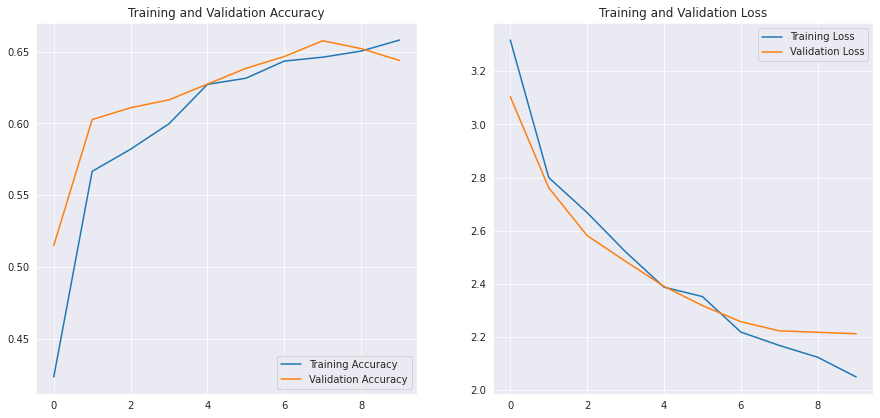

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(ep)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
test_images = []
for img_path in X_test:
    img_arr = cv2.imread(img_path)[...,::-1]
    resized_arr = cv2.resize(img_arr, (IMG_H, IMG_W))
    test_images.append(resized_arr)

In [25]:
test_images = np.array(test_images) / 255
test_images.reshape(-1, IMG_H, IMG_W, 1)
zzzzzzz = 0

In [26]:
predictions = np.argmax(model.predict(test_images, batch_size=BATCH_SIZE), axis=-1)
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test, predictions, target_names = ['Ignore (Class 0)','safe pedestrian (Class 1)', 'Be careful (Class 2)', 'Break (Class 3)']))

                           precision    recall  f1-score   support

         Ignore (Class 0)       1.00      0.01      0.03        77
safe pedestrian (Class 1)       0.69      0.88      0.77       287
     Be careful (Class 2)       0.54      0.49      0.51        90
          Break (Class 3)       0.68      0.74      0.71        46

                 accuracy                           0.66       500
                macro avg       0.73      0.53      0.50       500
             weighted avg       0.71      0.66      0.60       500



In [27]:
confusion = tf.math.confusion_matrix(labels=y_test, predictions=predictions, num_classes=4)
print(confusion)

tf.Tensor(
[[  1  74   2   0]
 [  0 252  28   7]
 [  0  37  44   9]
 [  0   4   8  34]], shape=(4, 4), dtype=int32)


In [28]:
saved_model_dir = 'saved_models'
tf.saved_model.save(model, saved_model_dir)

2023-01-04 21:01:48.581850: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [29]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

2023-01-04 21:02:24.180628: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2023-01-04 21:02:24.180731: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2023-01-04 21:02:24.180744: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored change_concat_input_ranges.
2023-01-04 21:02:24.183949: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: saved_models
2023-01-04 21:02:24.256644: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2023-01-04 21:02:24.256765: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: saved_models
2023-01-04 21:02:24.257137: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-04 21:02:24.517770: I tensorflow/cc/saved_mo

In [30]:
with open('mobilenet_08_12_9am.tflite', 'wb') as f:
  f.write(tflite_model)

class ModelSpecificInfo(object):
  """Holds information that is specificly tied to an image classifier."""

  def __init__(self, name, version, image_width, image_height, image_min,
               image_max, mean, std, num_classes, author):
    self.name = name
    self.version = version
    self.image_width = image_width
    self.image_height = image_height
    self.image_min = image_min
    self.image_max = image_max
    self.mean = mean
    self.std = std
    self.num_classes = num_classes
    self.author = author

_MODEL_INFO = {
    "mobilenet_08_12_9am.tflite":
        ModelSpecificInfo(
            name="MobileNetV2",
            version="v1",
            image_width=512,
            image_height=512,
            image_min=0,
            image_max=255,
            mean=[127.5],
            std=[127.5],
            num_classes=4,
            author="TensorFlow")
}

In [31]:
class MetadataPopulatorForImageClassifier(object):
  """Populates the metadata for an image classifier."""

  def __init__(self, model_file, model_info, label_file_path):
    self.model_file = model_file
    self.model_info = model_info
    self.label_file_path = label_file_path
    self.metadata_buf = None

  def populate(self):
    """Creates metadata and then populates it for an image classifier."""
    self._create_metadata()
    self._populate_metadata()

  def _create_metadata(self):
    """Creates the metadata for an image classifier."""

    # Creates model info.
    model_meta = _metadata_fb.ModelMetadataT()
    model_meta.name = self.model_info.name
    model_meta.description = ("Identify the most prominent object in the "
                              "image from a set of %d categories." %
                              self.model_info.num_classes)
    model_meta.version = self.model_info.version
    model_meta.author = self.model_info.author
    model_meta.license = ("Apache License. Version 2.0 "
                          "http://www.apache.org/licenses/LICENSE-2.0.")

    # Creates input info.
    input_meta = _metadata_fb.TensorMetadataT()
    input_meta.name = "image"
    input_meta.description = (
        "Input image to be classified. The expected image is {0} x {1}, with "
        "three channels (red, blue, and green) per pixel. Each value in the "
        "tensor is a single byte between {2} and {3}.".format(
            self.model_info.image_width, self.model_info.image_height,
            self.model_info.image_min, self.model_info.image_max))
    input_meta.content = _metadata_fb.ContentT()
    input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
    input_meta.content.contentProperties.colorSpace = (
        _metadata_fb.ColorSpaceType.RGB)
    input_meta.content.contentPropertiesType = (
        _metadata_fb.ContentProperties.ImageProperties)
    input_normalization = _metadata_fb.ProcessUnitT()
    input_normalization.optionsType = (
        _metadata_fb.ProcessUnitOptions.NormalizationOptions)
    input_normalization.options = _metadata_fb.NormalizationOptionsT()
    input_normalization.options.mean = self.model_info.mean
    input_normalization.options.std = self.model_info.std
    input_meta.processUnits = [input_normalization]
    input_stats = _metadata_fb.StatsT()
    input_stats.max = [self.model_info.image_max]
    input_stats.min = [self.model_info.image_min]
    input_meta.stats = input_stats

    # Creates output info.
    output_meta = _metadata_fb.TensorMetadataT()
    output_meta.name = "probability"
    output_meta.description = "Probabilities of the %d labels respectively." % self.model_info.num_classes
    output_meta.content = _metadata_fb.ContentT()
    output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
    output_meta.content.contentPropertiesType = (
        _metadata_fb.ContentProperties.FeatureProperties)
    output_stats = _metadata_fb.StatsT()
    output_stats.max = [1.0]
    output_stats.min = [0.0]
    output_meta.stats = output_stats
    label_file = _metadata_fb.AssociatedFileT()
    label_file.name = os.path.basename(self.label_file_path)
    label_file.description = "Labels for objects that the model can recognize."
    label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
    output_meta.associatedFiles = [label_file]

    # Creates subgraph info.
    subgraph = _metadata_fb.SubGraphMetadataT()
    subgraph.inputTensorMetadata = [input_meta]
    subgraph.outputTensorMetadata = [output_meta]
    model_meta.subgraphMetadata = [subgraph]

    b = flatbuffers.Builder(0)
    b.Finish(
        model_meta.Pack(b),
        _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
    self.metadata_buf = b.Output()

  def _populate_metadata(self):
    """Populates metadata and label file to the model file."""
    populator = _metadata.MetadataPopulator.with_model_file(self.model_file)
    populator.load_metadata_buffer(self.metadata_buf)
    populator.load_associated_files([self.label_file_path])
    populator.populate()


In [32]:
import flatbuffers
model_file = "mobilenet_08_12_9am.tflite"
model_basename = os.path.basename(model_file)

export_model_path = os.path.join(saved_model_dir, model_basename)

# Copies model_file to export_path.
tf.io.gfile.copy(model_file, export_model_path, overwrite=True)

# Generate the metadata objects and put them in the model file
populator = MetadataPopulatorForImageClassifier(
  export_model_path, _MODEL_INFO.get(model_file), "../input/citypersondata-annot/labels.txt")
populator.populate()

In [33]:
displayer = _metadata.MetadataDisplayer.with_model_file(export_model_path)
export_json_file = os.path.join(saved_model_dir, os.path.splitext(model_basename)[0] + ".json")
json_file = displayer.get_metadata_json()
with open(export_json_file, "w") as f:
    f.write(json_file)

In [34]:
print("Finished populating metadata and associated file to the model:")
print(model_file)
print("The metadata json file has been saved to:")
print(export_json_file)
print("The associated file that has been been packed to the model is:")
print(displayer.get_packed_associated_file_list())

Finished populating metadata and associated file to the model:
mobilenet_08_12_9am.tflite
The metadata json file has been saved to:
saved_models/mobilenet_08_12_9am.json
The associated file that has been been packed to the model is:
['labels.txt']
